# Validate the monthly means of modeled Bering Strait Transports
This notebook compares the monthly means for the freshwater flux, heat flux, and volume transport through Bering Strait using the Woodgate moored observational product (1991-2019) and the following CM4 simulations:
1. CMIP6-CM4
2. Odiv-200
3. Odiv-209

Transports and fluxes are calculated using the definitions from from Woodgate et al. 2018. Model transport, $T_{vol}$, is the meridonal mass transport, $vmo$, divided by the reference density, $\rho_0$. 

The freshwater flux, $T_{FW}$ is calculated as follows:
$$T_{FW} = T_{vol} \left( 1 - \frac{S}{S_{ref}} \right)$$ where $S_{ref} = 34.8$ psu.

Heat fluxes, $T_{Heat}$, are calculated as follows:
$$T_{Heat} = \rho T_{vol} c_w \left( \theta - \theta_{ref} \right)$$ where $\theta_{ref} = -1.9^\circ C$, $\rho = 1023$ kg m$^{-3}$ ; and $c_w = 3900$ J(kg K)$^{-1}$.

Transports and fluxes are calculated at each grid point and then intergrated across Bering Strait's cross-sectional area.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np
import cmocean

## Set up DASK cluster
In dask labextension, create a +NEW cluster. Click the < > widget, scale it to 16 workers and let's go!

## Set parameters

In [3]:
# Reference salinity for freshwater flux [PSU]
S_ref = 34.8
# Reference potential temperature for heat flux [deg C]
theta_ref = -1.9
# Model reference density [kg/m3]
rho_0 = 1035
# Heat capacity of water for model output [J/kg K]
C_p = 3992
# Lat, Lon, depth of mooring observations
llz_moor = [66 + (19.6/60), -168 - (57.5/60), 57]
# Cross-sectional area of strait [m^2]
area_BS = 4.25e6

## Set paths

In [4]:
## CMIP6 CM4
# base
base_cmip6 = '/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/'
# pi
cmip6_PI = base_cmip6 + 'CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Bering_Strait/'
# CM4 historical
cmip6_HI = base_cmip6 + 'CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Bering_Strait/'

In [5]:
# base for high res experiments
base_hres = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/'
## ODiv 191
# 0.8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 10 days
odiv191_PI = base_hres + 'CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 200
# 0.8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days
odiv200_PI = base_hres + 'CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 206
# 0.8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning but starts at year 180
odiv206_PI = base_hres + 'CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 207
# 0.8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8 but starts at year 180
odiv207_PI = base_hres + 'CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 209
# 0.8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8
odiv209_PI = base_hres + 'CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'

In [6]:
# output directories
cmip6_PI_dir = cmip6_PI + 'ts/daily/5yr/'
cmip6_HI_dir = cmip6_HI + 'ts/daily/5yr/'
odiv200_PI_dir = odiv200_PI + 'ts/daily/10yr/'
odiv209_PI_dir = odiv209_PI + 'ts/daily/10yr/'

## Get model file lists

In [7]:
## CMIP6 CM4
# pi
filelistCMIP6pi = glob(f'{cmip6_PI_dir}*.nc')
# historical
filelistCMIP6hi = glob(f'{cmip6_HI_dir}*.nc')

In [8]:
## ODIV200 CM4
# pi
filelistODIV200 = glob(f'{odiv200_PI_dir}*.nc')
# historical

In [9]:
## ODIV209 CM4
# pi
filelistODIV209 = glob(f'{odiv209_PI_dir}*.nc')
# historical

## Read in model data

In [10]:
# CMIP6 CM4 pi
DS_cmip6pi = xr.open_mfdataset(filelistCMIP6pi,use_cftime=True,combine='by_coords',
                             engine='netcdf4',drop_variables=['average_DT', 'average_T1', 'average_T2']
                            ).rename_dims({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                         ).rename({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                                 ).squeeze().chunk({'time':10000})

In [11]:
# CMIP6 CM4 historical
DS_cmip6hi = xr.open_mfdataset(filelistCMIP6hi,use_cftime=True,combine='by_coords',
                             engine='netcdf4',drop_variables=['average_DT', 'average_T1', 'average_T2']
                            ).rename_dims({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                         ).rename({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                                 ).squeeze().chunk({'time':10000})

In [12]:
# ODIV200 CM4
DS_o200 = xr.open_mfdataset(filelistODIV200,use_cftime=True,combine='by_coords',
                             engine='netcdf4',drop_variables=['average_DT', 'average_T1', 'average_T2']
                            ).rename_dims({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                         ).rename({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                                 ).squeeze().chunk({'time':10000})
# Fix weirdness with vmo coord
DS_o200['vmo'] = DS_o200.vmo.assign_coords(xh=("xh_sub02", DS_o200.xh)).swap_dims({"xh_sub02": "xh"})
DS_o200['vo'] = DS_o200.vo.assign_coords(xh=("xh_sub02", DS_o200.xh)).swap_dims({"xh_sub02": "xh"})

In [13]:
# ODIV209 CM4
DS_o209 = xr.open_mfdataset(filelistODIV209,use_cftime=True,combine='by_coords',
                             engine='netcdf4',drop_variables=['average_DT', 'average_T1', 'average_T2']
                            ).rename_dims({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                         ).rename({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                                 ).squeeze().chunk({'time':30000})
# Fix weirdness with vmo coord
DS_o209['vmo'] = DS_o209.vmo.assign_coords(xh=("xh_sub02", DS_o209.xh)).swap_dims({"xh_sub02": "xh"})
DS_o209['vo'] = DS_o209.vo.assign_coords(xh=("xh_sub02", DS_o209.xh)).swap_dims({"xh_sub02": "xh"})

## Open Ocean Static

In [14]:
# CMIP6 CM4
OS_cmip6 = xr.open_dataset(cmip6_PI + 'ocean_Bering_Strait.static.nc',engine='netcdf4')

In [15]:
# ODIV200 CM4
OS_o200 = xr.open_dataset(odiv200_PI + 'ocean_Bering_Strait.static.nc',engine='netcdf4')

In [16]:
# ODIV209 CM4
OS_o209 = xr.open_dataset(odiv209_PI + 'ocean_Bering_Strait.static.nc',engine='netcdf4')

## Assign geolat, geolon, and dy to outputs

In [17]:
# CMIP6 CM4
DS_cmip6pi = DS_cmip6pi.assign_coords({'geolon':OS_cmip6['geolon'].sel(xh=DS_cmip6pi.xh,yh=DS_cmip6pi.yh),
                                       'geolat':OS_cmip6['geolat'].sel(xh=DS_cmip6pi.xh,yh=DS_cmip6pi.yh),
                                       'geolon_v':OS_cmip6['geolon_v'].sel(xh=DS_cmip6pi.xh,yq=DS_cmip6pi.yq),
                                       'geolat_v':OS_cmip6['geolat_v'].sel(xh=DS_cmip6pi.xh,yq=DS_cmip6pi.yq)})
DS_cmip6pi['dyCv'] = OS_cmip6['dyCv'].sel(xh=DS_cmip6pi.xh,yq=DS_cmip6pi.yq)

In [18]:
# CMIP6 CM4 historical
DS_cmip6hi = DS_cmip6hi.assign_coords({'geolon':OS_cmip6['geolon'].sel(xh=DS_cmip6hi.xh,yh=DS_cmip6hi.yh),
                                       'geolat':OS_cmip6['geolat'].sel(xh=DS_cmip6hi.xh,yh=DS_cmip6hi.yh),
                                       'geolon_v':OS_cmip6['geolon_v'].sel(xh=DS_cmip6hi.xh,yq=DS_cmip6hi.yq),
                                       'geolat_v':OS_cmip6['geolat_v'].sel(xh=DS_cmip6hi.xh,yq=DS_cmip6hi.yq)})
DS_cmip6hi['dyCv'] = OS_cmip6['dyCv'].sel(xh=DS_cmip6hi.xh,yq=DS_cmip6hi.yq)

In [19]:
# ODIV200 CM4
DS_o200 = DS_o200.assign_coords({'geolon':OS_o200['geolon'].sel(xh=DS_o200.xh,yh=DS_o200.yh),
                                 'geolat':OS_o200['geolat'].sel(xh=DS_o200.xh,yh=DS_o200.yh),
                                 'geolon_v':OS_o200['geolon_v'].sel(xh=DS_o200.xh,yq=DS_o200.yq),
                                 'geolat_v':OS_o200['geolat_v'].sel(xh=DS_o200.xh,yq=DS_o200.yq)})
DS_o200['dyCv'] = OS_o200['dyCv'].sel(xh=DS_o200.xh,yq=DS_o200.yq)

In [20]:
# ODIV209 CM4
DS_o209 = DS_o209.assign_coords({'geolon':OS_o209['geolon'].sel(xh=DS_o209.xh,yh=DS_o209.yh),
                                 'geolat':OS_o209['geolat'].sel(xh=DS_o209.xh,yh=DS_o209.yh),
                                 'geolon_v':OS_o209['geolon_v'].sel(xh=DS_o209.xh,yq=DS_o209.yq),
                                 'geolat_v':OS_o209['geolat_v'].sel(xh=DS_o209.xh,yq=DS_o209.yq)})
DS_o209['dyCv'] = OS_o209['dyCv'].sel(xh=DS_o209.xh,yq=DS_o209.yq)

## Quick check of PI data

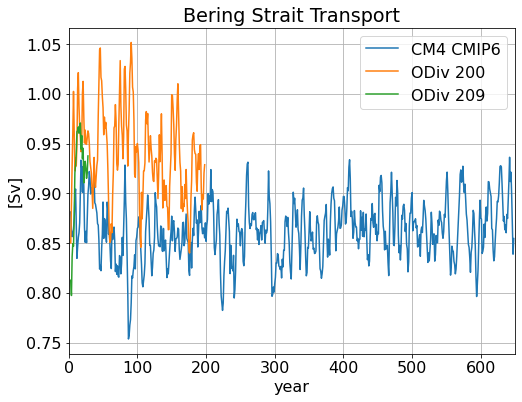

In [21]:
fig = plt.figure(figsize=(8,6))
(DS_cmip6pi.vmo.sum(dim=['z_l','xh'])*(10**-6)/rho_0).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=5,center=True).mean().plot(label='CM4 CMIP6')
(DS_o200.vmo.sum(dim=['z_l','xh'])*(10**-6)/rho_0).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=5,center=True).mean().plot(label='ODiv 200')
(DS_o209.vmo.sum(dim=['z_l','xh'])*(10**-6)/rho_0).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=5,center=True).mean().plot(label='ODiv 209')
plt.legend()
plt.title('Bering Strait Transport')
plt.ylabel('[Sv]')
plt.xlim(0,650)
plt.grid()
plt.show()

## Set observational paths

In [22]:
# Volume transport
fname_T = '../data/BeringStraitMooring/BeringStrait_Monthlymeans_TRANSPORT_Jan2021.txt'
# Heat flux
fname_H = '../data/BeringStraitMooring/BeringStrait_Monthlymeans_HEAT_Jan2021.txt'
# Freshwater flux
fname_F = '../data/BeringStraitMooring/BeringStrait_Monthlymeans_FW_Jan2021.txt'
# V velocity
fname_v = '../data/BeringStraitMooring/BeringStrait_Monthlymeans_VVEL_Jan2021.txt'
# Temperature
fname_theta = '../data/BeringStraitMooring/BeringStrait_Monthlymeans_TEMPERATURE_Jan2021.txt'
# Salinity
fname_S = '../data/BeringStraitMooring/BeringStrait_Monthlymeans_SALINITY_Jan2021.txt'

## Read in observational data

In [23]:
# Volume transport
BST = np.loadtxt(fname_T, comments='%')
# Heat flux
BSH = np.loadtxt(fname_H, comments='%')
# Freshwater flux
BSF = np.loadtxt(fname_F, comments='%')
# V velocity
BSV = np.loadtxt(fname_v, comments='%')
# Temperature
BStheta = np.loadtxt(fname_theta, comments='%')
# Salinity
BSS = np.loadtxt(fname_S, comments='%')

## Make observational time series

In [24]:
# Make time array
time = xr.cftime_range(start=BST[0,1].astype('int').astype('str'), periods=BST.shape[0],
                       freq="MS", calendar="noleap").shift(15,'D')

In [25]:
# Volume transport [Sv] (uncorrected for ACC)
T_vol  = BST[:,-2]
T_volE = BST[:,-1]

In [26]:
# Heat flux [TW] (uncorrected for ACC)
F_heat  = BSH[:,-2]
F_heatE = BSH[:,-1]

In [27]:
# Freshwater flux [Sv] (uncorrected for ACC)
F_fresh  = BSF[:,-2]
F_freshE = BSF[:,-1]

In [28]:
# V velocity [m/s]
vo  = BSV[:,-2]/100
voE = BSV[:,-1]/100

In [29]:
# Temperature [degC]
thetao  = BStheta[:,-2]
thetaoE = BStheta[:,-1]

In [30]:
# Salinity [PSU]
so  = BSS[:,-2]
soE = BSS[:,-1]

In [31]:
DS_obs = xr.Dataset(
    data_vars=dict(
        T_vol    = (["time"], T_vol),
        T_volE   = (["time"], T_volE),
        F_heat   = (["time"], F_heat),
        F_heatE  = (["time"], F_heatE),
        F_fresh  = (["time"], F_fresh),
        F_freshE = (["time"], F_freshE),
        vo       = (["time"], vo),
        voE      = (["time"], voE),
        thetao   = (["time"], thetao),
        thetaoE  = (["time"], thetaoE),
        so       = (["time"], so),
        soE      = (["time"], soE),
    ),
    coords=dict(
        time=time,
    ),
    attrs=dict(description="Bering Strait mooring transports and fluxes."),
)

## Check the Berring Strait cross-sectional area for each simulation

In [32]:
# CMIP6 CM4
area_cmip6 = (DS_cmip6pi.volcello.sum('z_l')/DS_cmip6pi.dyCv).sum('xh').mean('time').values
# HighRes CM4
area_hres = (DS_o200.volcello.sum('z_l')/DS_o200.dyCv).sum('xh').mean('time').values

In [33]:
print('Bering Strait cross-sectional area [m^3]')
print('Observations: %i' %area_BS)
print('   CMIP6 CM4: %i' %area_cmip6)
print(' HighRes CM4: %i' %area_hres)

Bering Strait cross-sectional area [m^3]
Observations: 4250000
   CMIP6 CM4: 4679148
 HighRes CM4: 4821945


In [34]:
print('Simulated Bering Strait frational cross-sectional area')
print('  CMIP6 CM4: %.3f' %(area_cmip6/area_BS))
print('HighRes CM4: %.3f' %(area_hres/area_BS))

Simulated Bering Strait frational cross-sectional area
  CMIP6 CM4: 1.101
HighRes CM4: 1.135


## Calc volume transports [m$^3$/s]

In [35]:
# CMIP6 CM4 pi
DS_cmip6pi['T_vol'] = DS_cmip6pi.vmo/rho_0

In [36]:
# CMIP6 CM4 historical
DS_cmip6hi['T_vol'] = DS_cmip6hi.vmo/rho_0

In [37]:
# ODIV200 CM4
DS_o200['T_vol'] = DS_o200.vmo/rho_0

In [38]:
# ODIV209 CM4
DS_o209['T_vol'] = DS_o209.vmo/rho_0

## Calculate Heat Fluxes [TW]

In [39]:
# CMIP6 CM4 pi
DS_cmip6pi['F_heat'] = rho_0 * DS_cmip6pi.T_vol * C_p * (DS_cmip6pi.thetao - theta_ref) * (10**-12)

In [40]:
# CMIP6 CM4 historical
DS_cmip6hi['F_heat'] = rho_0 * DS_cmip6hi.T_vol * C_p * (DS_cmip6hi.thetao - theta_ref) * (10**-12)

In [41]:
# ODIV200 CM4
DS_o200['F_heat'] = rho_0 * DS_o200.T_vol * C_p * (DS_o200.thetao - theta_ref) * (10**-12)

In [42]:
# ODIV209 CM4
DS_o209['F_heat'] = rho_0 * DS_o209.T_vol * C_p * (DS_o209.thetao - theta_ref) * (10**-12)

## Calculate Freshwater Fluxes [Sv]

In [43]:
# CMIP6 CM4 pi
DS_cmip6pi['F_fresh'] = DS_cmip6pi.T_vol * (1 - (DS_cmip6pi.so/S_ref)) * (10**-6)

In [44]:
# CMIP6 CM4 historical
DS_cmip6hi['F_fresh'] = DS_cmip6hi.T_vol * (1 - (DS_cmip6hi.so/S_ref)) * (10**-6)

In [45]:
# ODIV200 CM4
DS_o200['F_fresh'] = DS_o200.T_vol * (1 - (DS_o200.so/S_ref)) * (10**-6)

In [46]:
# ODIV209 CM4
DS_o209['F_fresh'] = DS_o209.T_vol * (1 - (DS_o209.so/S_ref)) * (10**-6)

## Plot volume transport climatology

In [47]:
# Make model time series
T_cm4P = (DS_cmip6pi.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.month').mean()
T_cm4H = (DS_cmip6hi.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.month').mean()
T_o200 = (DS_o200.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.month').mean()
T_o209 = (DS_o209.T_vol.sum(dim=['z_l','xh'])*(10**-6)).groupby('time.month').mean()
T_obs  = DS_obs.T_vol.groupby('time.month').mean()
T_obsE = DS_obs.T_volE.groupby('time.month').mean()

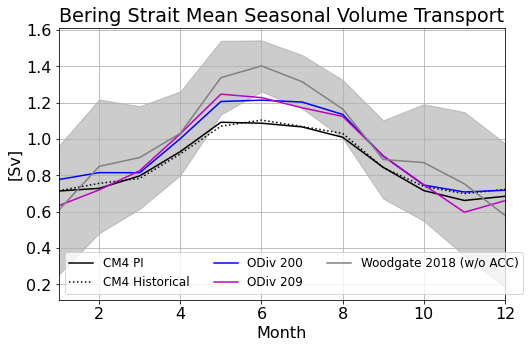

In [48]:
# Volume transport
fig = plt.figure(figsize=(8,5))
plt.plot(T_cm4P.month,T_cm4P,'k',label = 'CM4 PI')
plt.plot(T_cm4H.month,T_cm4H,'k:',label = 'CM4 Historical')
plt.plot(T_o200.month,T_o200,'b',label = 'ODiv 200')
plt.plot(T_o209.month,T_o209,'m',label = 'ODiv 209')
plt.fill_between(T_obs.month,T_obs-T_obsE,T_obs+T_obsE,color='grey',alpha=0.4)
plt.plot(T_obs.month,T_obs,'grey',label = 'Woodgate 2018 (w/o ACC)')
plt.title('Bering Strait Mean Seasonal Volume Transport')
plt.ylabel('[Sv]')
plt.xlabel('Month')
plt.legend(ncol=3,prop={'size': 12})
plt.xlim(1,12)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Tvol_monthly_modelPIObs.pdf')

## Plot heat flux climatology

In [49]:
# Make model time series
H_cm4P = DS_cmip6pi.F_heat.sum(dim=['z_l','xh']).groupby('time.month').mean()
H_cm4H = DS_cmip6hi.F_heat.sum(dim=['z_l','xh']).groupby('time.month').mean()
H_o200 = DS_o200.F_heat.sum(dim=['z_l','xh']).groupby('time.month').mean()
H_o209 = DS_o209.F_heat.sum(dim=['z_l','xh']).groupby('time.month').mean()
H_obs  = DS_obs.F_heat.groupby('time.month').mean()
H_obsE = DS_obs.F_heatE.groupby('time.month').mean()

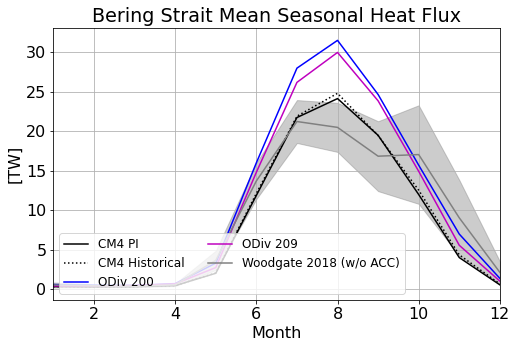

In [50]:
# Heat flux
fig = plt.figure(figsize=(8,5))
plt.plot(H_cm4P.month,H_cm4P,'k',label = 'CM4 PI')
plt.plot(H_cm4H.month,H_cm4H,'k:',label = 'CM4 Historical')
plt.plot(H_o200.month,H_o200,'b',label = 'ODiv 200')
plt.plot(H_o209.month,H_o209,'m',label = 'ODiv 209')
plt.fill_between(H_obs.month,H_obs-H_obsE,H_obs+H_obsE,color='grey',alpha=0.4)
plt.plot(H_obs.month,H_obs,'grey',label = 'Woodgate 2018 (w/o ACC)')
plt.title('Bering Strait Mean Seasonal Heat Flux')
plt.ylabel('[TW]')
plt.xlabel('Month')
plt.legend(ncol=2,loc='lower left',prop={'size': 12})
plt.xlim(1,12)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Fheat_monthly_modelPIObs.pdf')

## Plot freshwater flux climatology

In [51]:
# Make model time series
F_cm4P = DS_cmip6pi.F_fresh.sum(dim=['z_l','xh']).groupby('time.month').mean()
F_cm4H = DS_cmip6hi.F_fresh.sum(dim=['z_l','xh']).groupby('time.month').mean()
F_o200 = DS_o200.F_fresh.sum(dim=['z_l','xh']).groupby('time.month').mean()
F_o209 = DS_o209.F_fresh.sum(dim=['z_l','xh']).groupby('time.month').mean()
F_obs  = DS_obs.F_fresh.groupby('time.month').mean()
F_obsE = DS_obs.F_fresh.groupby('time.month').mean()

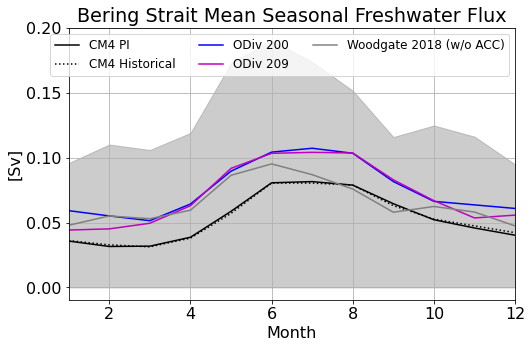

In [52]:
# Volume transport
fig = plt.figure(figsize=(8,5))
plt.plot(F_cm4P.month,F_cm4P,'k',label = 'CM4 PI')
plt.plot(F_cm4H.month,F_cm4H,'k:',label = 'CM4 Historical')
plt.plot(F_o200.month,F_o200,'b',label = 'ODiv 200')
plt.plot(F_o209.month,F_o209,'m',label = 'ODiv 209')
plt.fill_between(F_obs.month,F_obs-F_obsE,F_obs+F_obsE,color='grey',alpha=0.4)
plt.plot(F_obs.month,F_obs,'grey',label = 'Woodgate 2018 (w/o ACC)')
plt.title('Bering Strait Mean Seasonal Freshwater Flux')
plt.ylabel('[Sv]')
plt.xlabel('Month')
plt.legend(ncol=3,prop={'size': 12})
plt.xlim(1,12)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Ffresh_monthly_modelPIObs.pdf')

## Plot v velocity climatology for mooring location

In [53]:
# Make time series
v_cm4P = DS_cmip6pi.vo.isel(
    xh=abs(DS_cmip6pi.geolon_v - llz_moor[1]).argmin()).sel(
    z_l=llz_moor[-1],method='nearest').groupby('time.month').mean()
v_cm4H = DS_cmip6hi.vo.isel(
    xh=abs(DS_cmip6hi.geolon_v - llz_moor[1]).argmin()).sel(
    z_l=llz_moor[-1],method='nearest').groupby('time.month').mean()
v_o200 = DS_o200.vo.isel(
    xh=abs(DS_o200.geolon_v - llz_moor[1]).argmin()).sel(
    z_l=llz_moor[-1],method='nearest').groupby('time.month').mean()
v_o209 = DS_o209.vo.isel(
    xh=abs(DS_o209.geolon_v - llz_moor[1]).argmin()).sel(
    z_l=llz_moor[-1],method='nearest').groupby('time.month').mean()
v_obs  = DS_obs.vo.groupby('time.month').mean()
v_obsE = DS_obs.voE.groupby('time.month').mean()

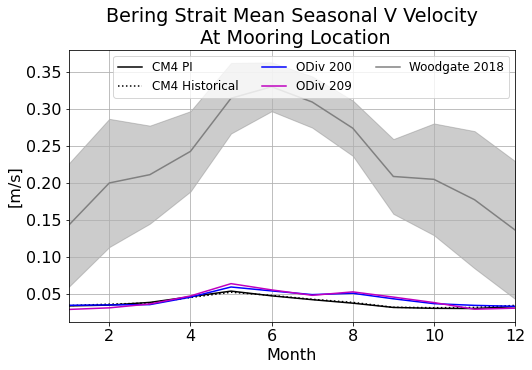

In [54]:
# V velocity
fig = plt.figure(figsize=(8,5))
plt.plot(v_cm4P.month,v_cm4P,'k',label = 'CM4 PI')
plt.plot(v_cm4H.month,v_cm4H,'k:',label = 'CM4 Historical')
plt.plot(v_o200.month,v_o200,'b',label = 'ODiv 200')
plt.plot(v_o209.month,v_o209,'m',label = 'ODiv 209')
plt.fill_between(v_obs.month,v_obs-v_obsE,v_obs+v_obsE,color='grey',alpha=0.4)
plt.plot(v_obs.month,v_obs,'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Mean Seasonal V Velocity\n At Mooring Location')
plt.ylabel('[m/s]')
plt.xlabel('Month')
plt.legend(ncol=3,prop={'size': 12})
plt.xlim(1,12)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/vo_monthly_modelPIObs.pdf')

## Plot v velocity climatology for mooring depth

In [55]:
# Make time series
v_cm4P = DS_cmip6pi.vo.sel(z_l=llz_moor[-1],method='nearest').mean(
    'xh').groupby('time.month').mean()
v_cm4H = DS_cmip6hi.vo.sel(z_l=llz_moor[-1],method='nearest').mean(
    'xh').groupby('time.month').mean()
v_o200 = DS_o200.vo.sel(z_l=llz_moor[-1],method='nearest').mean(
    'xh').groupby('time.month').mean()
v_o209 = DS_o209.vo.sel(z_l=llz_moor[-1],method='nearest').mean(
    'xh').groupby('time.month').mean()
v_obs  = DS_obs.vo.groupby('time.month').mean()
v_obsE = DS_obs.voE.groupby('time.month').mean()

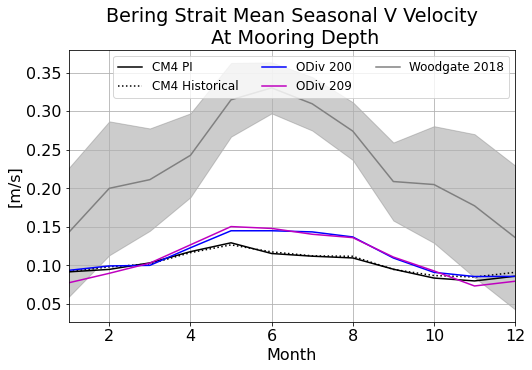

In [56]:
# V velocity
fig = plt.figure(figsize=(8,5))
plt.plot(v_cm4P.month,v_cm4P,'k',label = 'CM4 PI')
plt.plot(v_cm4H.month,v_cm4H,'k:',label = 'CM4 Historical')
plt.plot(v_o200.month,v_o200,'b',label = 'ODiv 200')
plt.plot(v_o209.month,v_o209,'m',label = 'ODiv 209')
plt.fill_between(v_obs.month,v_obs-v_obsE,v_obs+v_obsE,color='grey',alpha=0.4)
plt.plot(v_obs.month,v_obs,'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Mean Seasonal V Velocity\n At Mooring Depth')
plt.ylabel('[m/s]')
plt.xlabel('Month')
plt.legend(ncol=3,prop={'size': 12})
plt.xlim(1,12)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/vo_mz_monthly_modelPIObs.pdf')

## Plot temperature climatology for mooring location

In [57]:
# Make time series
T_cm4P = DS_cmip6pi.thetao.isel(
    xh=abs(DS_cmip6pi.geolon_v - llz_moor[1]).argmin()).sel(
    z_l=llz_moor[-1],method='nearest').groupby('time.month').mean()
T_cm4H = DS_cmip6hi.thetao.isel(
    xh=abs(DS_cmip6hi.geolon_v - llz_moor[1]).argmin()).sel(
    z_l=llz_moor[-1],method='nearest').groupby('time.month').mean()
T_o200 = DS_o200.thetao.isel(
    xh=abs(DS_o200.geolon_v - llz_moor[1]).argmin()).sel(
    z_l=llz_moor[-1],method='nearest').groupby('time.month').mean()
T_o209 = DS_o209.thetao.isel(
    xh=abs(DS_o209.geolon_v - llz_moor[1]).argmin()).sel(
    z_l=llz_moor[-1],method='nearest').groupby('time.month').mean()
T_obs  = DS_obs.thetao.groupby('time.month').mean()
T_obsE = DS_obs.thetaoE.groupby('time.month').mean()

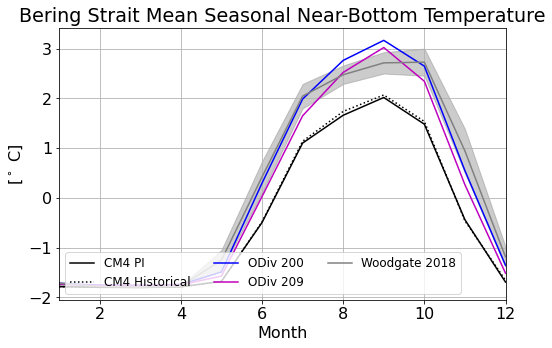

In [58]:
# V velocity
fig = plt.figure(figsize=(8,5))
plt.plot(T_cm4P.month,T_cm4P,'k',label = 'CM4 PI')
plt.plot(T_cm4H.month,T_cm4H,'k:',label = 'CM4 Historical')
plt.plot(T_o200.month,T_o200,'b',label = 'ODiv 200')
plt.plot(T_o209.month,T_o209,'m',label = 'ODiv 209')
plt.fill_between(T_obs.month,T_obs-T_obsE,T_obs+T_obsE,color='grey',alpha=0.4)
plt.plot(T_obs.month,T_obs,'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Mean Seasonal Near-Bottom Temperature')
plt.ylabel('[$^\circ$ C]')
plt.xlabel('Month')
plt.legend(ncol=3,prop={'size': 12},loc='lower left')
plt.xlim(1,12)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/thetao_monthly_modelPIObs.pdf')

## Plot salinity climatology for mooring location

In [59]:
# Make time series
S_cm4P = DS_cmip6pi.so.isel(
    xh=abs(DS_cmip6pi.geolon_v - llz_moor[1]).argmin()).sel(
    z_l=llz_moor[-1],method='nearest').groupby('time.month').mean()
S_cm4H = DS_cmip6hi.so.isel(
    xh=abs(DS_cmip6hi.geolon_v - llz_moor[1]).argmin()).sel(
    z_l=llz_moor[-1],method='nearest').groupby('time.month').mean()
S_o200 = DS_o200.so.isel(
    xh=abs(DS_o200.geolon_v - llz_moor[1]).argmin()).sel(
    z_l=llz_moor[-1],method='nearest').groupby('time.month').mean()
S_o209 = DS_o209.so.isel(
    xh=abs(DS_o209.geolon_v - llz_moor[1]).argmin()).sel(
    z_l=llz_moor[-1],method='nearest').groupby('time.month').mean()
S_obs  = DS_obs.so.groupby('time.month').mean()
S_obsE = DS_obs.soE.groupby('time.month').mean()

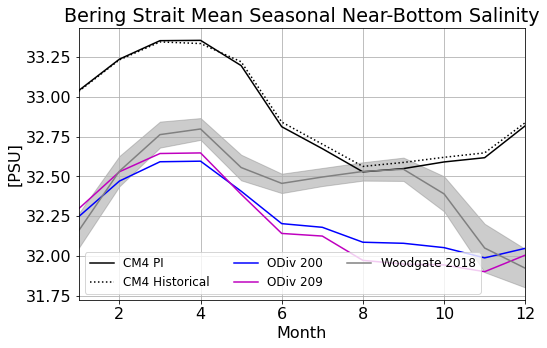

In [60]:
# V velocity
fig = plt.figure(figsize=(8,5))
plt.plot(S_cm4P.month,S_cm4P,'k',label = 'CM4 PI')
plt.plot(S_cm4H.month,S_cm4H,'k:',label = 'CM4 Historical')
plt.plot(S_o200.month,S_o200,'b',label = 'ODiv 200')
plt.plot(S_o209.month,S_o209,'m',label = 'ODiv 209')
plt.fill_between(S_obs.month,S_obs-S_obsE,S_obs+S_obsE,color='grey',alpha=0.4)
plt.plot(S_obs.month,S_obs,'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Mean Seasonal Near-Bottom Salinity')
plt.ylabel('[PSU]')
plt.xlabel('Month')
plt.legend(ncol=3,prop={'size': 12})
plt.xlim(1,12)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/so_monthly_modelPIObs.pdf')